In [134]:
import sys
python = sys.executable # get python executable path
print(python)

for i in ["numpy",  "scipy", "matplotlib", "pandas", "opencv-python", "opencv-contrib-python"]: # declare what packages we need
  print(f"Installing: {i}")
  ! $python -m pip install $i # install packages calling bash command from the notebook, e.g. "/usr/bin/python -m pip install numpy"

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import cv2

/usr/bin/python3
Installing: numpy
Installing: scipy
Installing: matplotlib
Installing: pandas
Installing: opencv-python
Installing: opencv-contrib-python


## Загрузка изображения

In [135]:
url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"
urllib.request.urlretrieve(url, "image.jpg")


('image.jpg', <http.client.HTTPMessage at 0x7d78e0105420>)

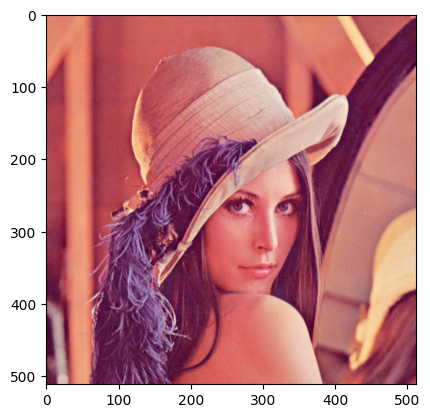

In [136]:
img = cv2.imread("image.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [137]:
img.shape

(512, 512, 3)

# Задание 1 Изменение размера изображения

## 1.1 Увеличение и уменьшение изображения методом ближайшего соседа

Функцию по изменению размера при помощи метода ближайшего соседа можно обобщить для увеличения и уменьшения изображения в произвольное количество раз по обеим осям (например, ширину увеличить в 2 раза, а длину уменьшить в 3 раза).

Поэтому в пункте 2 ЛР не будет имплементирована функция *downsample_1(img,
size_factor)*; она будет реализована в функции:

```
resize_nn(img: np.ndarray, resize_factor: tuple[float, float]) -> np.ndarray:
    ...
```

Она на вход будет принимать исходное изображение, а также кортеж с коэффициентами, которые показывают степень изменения изображения.

Если мы хотим увеличить изображение в $n$ раз, то подаем значение $n$.

Если мы хотим уменьшить изображение в $n$ раз, то подаем значение $\cfrac{1}{n}$.

In [138]:
def resize_nn_channel(img_channel: np.ndarray, resize_factor: tuple[float, float]) -> np.ndarray:
    height, width = img_channel.shape

    new_height, new_width = round(height * resize_factor[0]), round(width * resize_factor[1])
    new_image_channel = np.zeros((new_height, new_width))

    a_h, b_h = np.linalg.solve(np.array([
        [-0.5, 1],
        [new_height - 0.5 , 1]
    ]), np.array([-0.5, height - 0.5]))

    a_w, b_w = np.linalg.solve(np.array([
        [-0.5, 1],
        [new_width - 0.5 , 1]
    ]), np.array([-0.5, width - 0.5]))

    f = lambda h, w: (
        a_h * h + b_h,
        a_w * w + b_w
    )

    for i in range(new_height):
        for j in range(new_width):
            old_i, old_j = f(i, j)
            new_image_channel[i, j] = img_channel[
                round(old_i), round(old_j)
            ]

    return new_image_channel

In [139]:
def resize_nn(img: np.ndarray, resize_factor: tuple[float, float]) -> np.ndarray:
    return np.stack([
        resize_nn_channel(channel, resize_factor) for channel in img.transpose(2, 0, 1)
    ]).transpose(1, 2, 0)

Пример работы функции

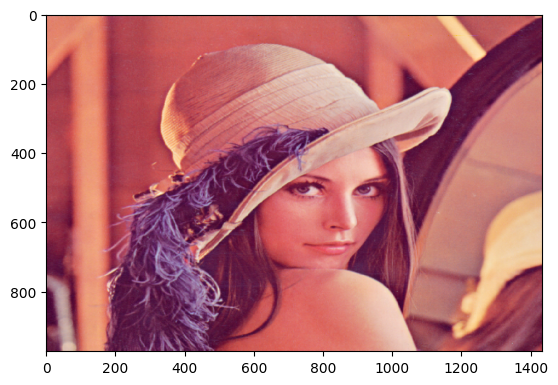

In [140]:
# увеличение обеих осей

plt.imshow(resize_nn(img / 255, (1.9, 2.8)));

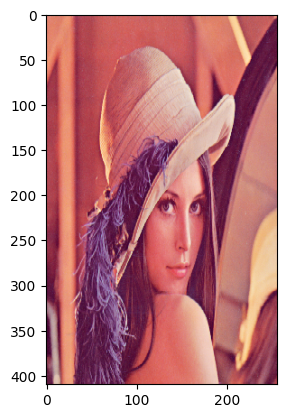

In [141]:
# уменьшение обеих осей

plt.imshow(resize_nn(img / 255, (0.8, 0.5)));

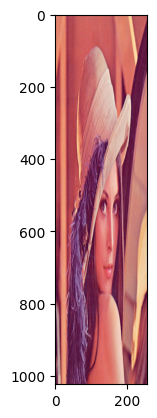

In [142]:
# уменьшение высоты и увеличение ширины

plt.imshow(resize_nn(img / 255, (2, 0.5)));

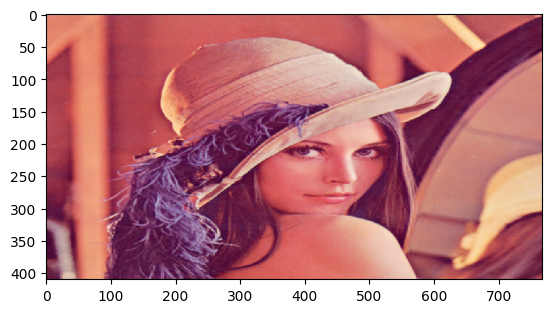

In [143]:
# увеличение высоты и уменьшение ширины

plt.imshow(resize_nn(img / 255, (0.8, 1.5)));

## 1.2 Увеличение и уменьшение изображения методом билинейной интерполяции

Аналогично, при данной реализации функция *resize_bilinear* также способна и увеличивать изображение, и уменьшать его.

In [144]:
import math


def resize_bilinear_channel(img_channel: np.ndarray, resize_factor: tuple[float, float]) -> np.ndarray:
    height, width = img_channel.shape

    new_height, new_width = round(height * resize_factor[0]), round(width * resize_factor[1])
    new_image_channel = np.zeros((new_height, new_width))

    a_h, b_h = np.linalg.solve(np.array([
        [-0.5, 1],
        [new_height - 0.5 , 1]
    ]), np.array([-0.5, height - 0.5]))

    a_w, b_w = np.linalg.solve(np.array([
        [-0.5, 1],
        [new_width - 0.5 , 1]
    ]), np.array([-0.5, width - 0.5]))

    f = lambda h, w: (
        a_h * h + b_h,
        a_w * w + b_w
    )

    for i in range(new_height):
        for j in range(new_width):
            old_i, old_j = f(i, j)

            V1 = (math.floor(old_i) - 1, math.floor(old_j) - 1)
            V2 = (math.ceil(old_i) - 1, math.floor(old_j) - 1)
            V3 = (math.floor(old_i) - 1, math.ceil(old_j) - 1)
            V4 = (math.ceil(old_i) - 1, math.ceil(old_j) - 1)

            d1 = old_i - V1[0]
            d2 = V2[0] - V1[0] - d1
            d3 = old_j - V1[1]
            d4 = V3[1] - V1[1] - d3

            q1 = img_channel[V1] * d2 + img_channel[V2] * d1
            q2 = img_channel[V3] * d2 + img_channel[V4] * d1
            q = q1 * d4 + q2 * d3

            new_image_channel[i, j] = q

    return new_image_channel

In [145]:
def resize_bilinear(img: np.ndarray, resize_factor: tuple[float, float]) -> np.ndarray:
    return np.stack([
        resize_bilinear_channel(channel, resize_factor) for channel in img.transpose(2, 0, 1)
    ]).transpose(1, 2, 0)

Пример работы функции

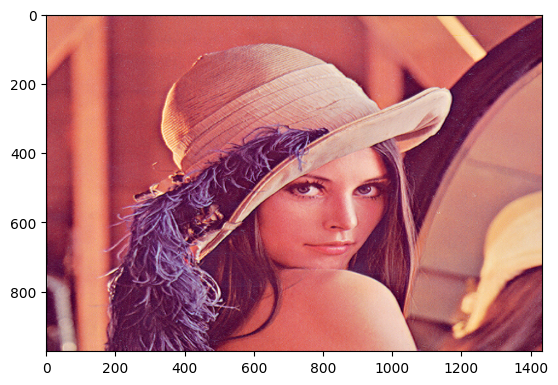

In [146]:
plt.imshow(resize_bilinear(img / 255, (1.9, 2.8)));

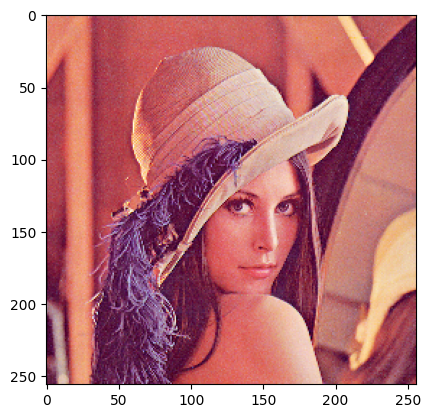

In [147]:
plt.imshow(resize_bilinear(img / 255, (0.5, 0.5)));

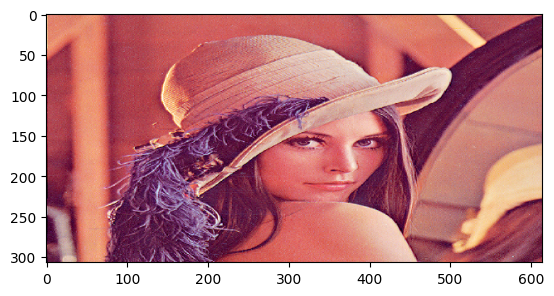

In [148]:
plt.imshow(resize_bilinear(img / 255, (0.6, 1.2)));

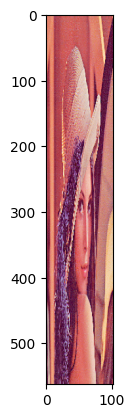

In [149]:
plt.imshow(resize_bilinear(img / 255, (1.1, 0.2)));

# Задание 2 Сжатие изображения



## 2.1 Сжатие изображения при помощи фильтров

Если обобщить процесс сжатия изображения при помощи Box-фильтра или при помощи фильтра Гаусса, получим следующую последовательность операций:
1. при помощи операции свертки применить фильтр к исходному изображению;
2. применить метод ближайшего соседа для изменения размера.

Поэтому реализуем операцию сертки для того, чтобы применять различные ядра к изображению.

### 2.1.1 Реализация операции свертки

In [150]:
def convolve(
        input_array: np.ndarray,
        kernel: np.ndarray,
        stride: tuple[int, int] = (1, 1),
        padding: list[tuple[int, int]] = [(0, 0), (0, 0)],
        padding_mode: str = 'constant',
        **kwargs
    ) -> np.ndarray:
    """
    padding_mode:
        'constant': окаймляет определенными значениями;
        'edge': дублирование цвета на границе;
        'reflect': отражение относительно краев;
    **kwargs:
        constant_values: значение на границе (если padding_mode = 'constant')
    """
    pad_input = np.pad(input_array, padding, mode=padding_mode, **kwargs)
    m, n = input_array.shape
    kernel_m, kernel_n = kernel.shape
    conv_m, conv_n = (m + sum(padding[0]) - kernel_m) // stride[0] + 1, (n + sum(padding[1]) - kernel_n) // stride[1] + 1
    conv = np.zeros((conv_m, conv_n))
    for i in range(0, conv_m, stride[0]):
        for j in range(0, conv_n, stride[1]):
            conv[i, j] = np.sum(
                kernel * pad_input[i: i + kernel_m, j: j + kernel_n]
            )
    return conv

Пример работы операции свертки

In [151]:
input_array = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])
kernel = np.array([
    [1, 1],
    [1, 1]
])
convolve(input_array, kernel, padding=[(1, 0), (1, 0)])

array([[ 1.,  3.,  5.],
       [ 5., 12., 16.],
       [11., 24., 28.]])

Пример применения Box-фильтра к каналу изображения

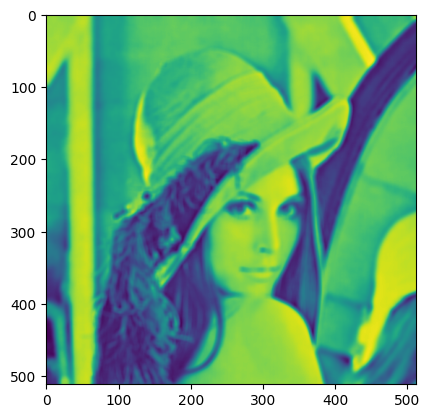

In [152]:
plt.imshow(convolve(img[:, :, 0] / 255, np.ones((7, 7)) / 49, padding=[(6, 0), (6, 0)], padding_mode='edge'))

### 2.1.2 Реализация метода по сжатию изображения при помощи свертки

In [153]:
def downsample_convolve_channel(img_channel: np.ndarray, kernel: np.ndarray, resize_factor: tuple[float, float]) -> np.ndarray:
    top, left = kernel.shape
    smooth_image = convolve(img_channel, kernel, padding=[(left - 1, 0), (top - 1, 0)], padding_mode='edge')
    return resize_nn_channel(smooth_image, resize_factor)

In [154]:
def downsample_convolve(img: np.ndarray, kernel: np.ndarray, resize_factor: tuple[float, float]) -> np.ndarray:
    return np.stack([
        downsample_convolve_channel(channel, kernel, resize_factor) for channel in img.transpose(2, 0, 1)
    ]).transpose(1, 2, 0)

Пример понижения размерности при помощи Box-фильтра

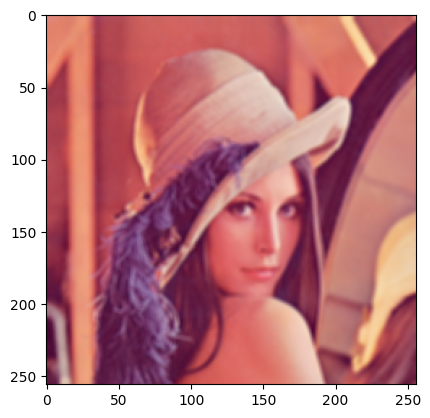

In [155]:
plt.imshow(downsample_convolve(img / 255, np.ones((7, 7)) / 49, (0.5, 0.5)))

Пример понижения размерности при помощи фильтра Гаусса

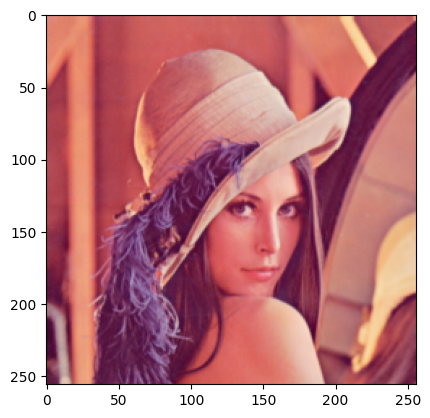

In [156]:
kernel = np.array([
    [0,  0,  1,   2,  1,  0, 0],
    [0,  3, 13,  22, 13,  3, 0],
    [1, 13, 59,  97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59,  97, 59, 13, 1],
    [0,  3, 13,  22, 13,  3, 0],
    [0,  0,  1,   2,  1,  0, 0],
])
plt.imshow(downsample_convolve(img / 255, kernel / np.sum(kernel), (0.5, 0.5)))

# Задание 3 Изменение яркости

## 3.1 Реализация функции для построения гистограммы изображения

In [157]:
def img_hist(img: np.ndarray) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    r, g, b = img[:, :, 0].reshape(-1), img[:, :, 1].reshape(-1), img[:, :, 2].reshape(-1)
    ax[0].imshow(img)
    ax[0].set_title('Исходное изображение');
    ax[1].hist(r, bins='auto', density=True, histtype='step', color='red');
    ax[1].hist(g, bins='auto', density=True, histtype='step', color='green');
    ax[1].hist(b, bins='auto', density=True, histtype='step', color='blue');
    ax[1].set_title('Гистограмма изображения');
    ax[1].set_xlabel('Интенсивность уровня серого');
    ax[1].set_ylabel('Значение плотности');
    ax[1].legend(['r', 'g', 'b']);

## 3.2 Реализация функции изменения уровня яркости

Будем полагать, что исходное изображение подается с форматом яркости пикселя в канале от 0 до 1. Отсюда получаем, что $a = 0$, $b = 1$, значит:

$$f(y, a, b) = (b - a) \cdot \cfrac{y - y_{min}}{y_{max} - y_{min}} = f(y, 0, 1) = \cfrac{y - y_{min}}{y_{max} - y_{min}}$$

In [158]:
import math


def linear_hist_transform_channel(img_channel: np.ndarray, persent: float) -> np.ndarray:
    variation_series, frequences = np.unique(img_channel, return_counts=True)
    N = len(variation_series)
    n_start, n_end = 0, N - 1
    p_start, p_end = 0, 0
    frequences = frequences / sum(frequences)

    while p_start < persent:
        p_start += frequences[n_start]
        n_start += 1

    while p_end < persent:
        p_end += frequences[n_end]
        n_end -= 1
    y_min, y_max = variation_series[n_start - 1], variation_series[n_end + 1]
    r = y_max - y_min

    f = np.vectorize(lambda y: (y - y_min) / (r + 1e-5))

    transform_channel = f(img_channel)
    transform_channel[transform_channel > 1] = 1
    transform_channel[transform_channel < 0] = 0

    return transform_channel

In [159]:
def linear_hist_transform(img: np.ndarray, persent: float = 0.05) -> np.ndarray:
    return np.stack([
        linear_hist_transform_channel(channel, persent) for channel in img.transpose(2, 0, 1)
    ]).transpose(1, 2, 0)

Пример изменения яркости и гистограммы

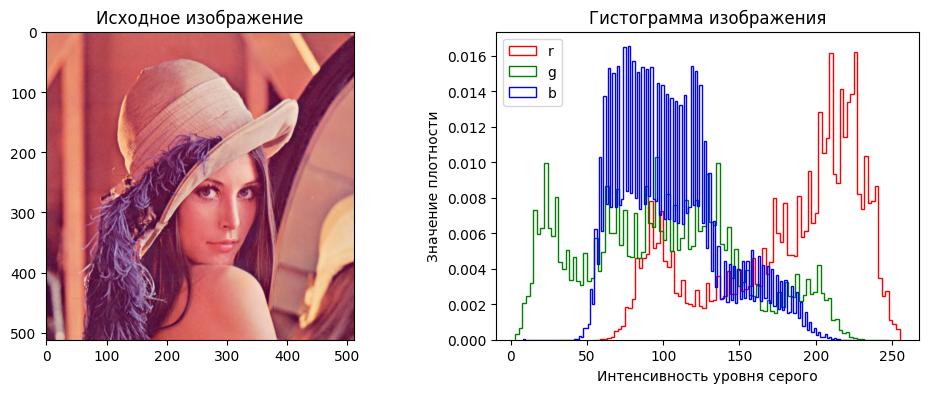

In [160]:
img_hist(img)

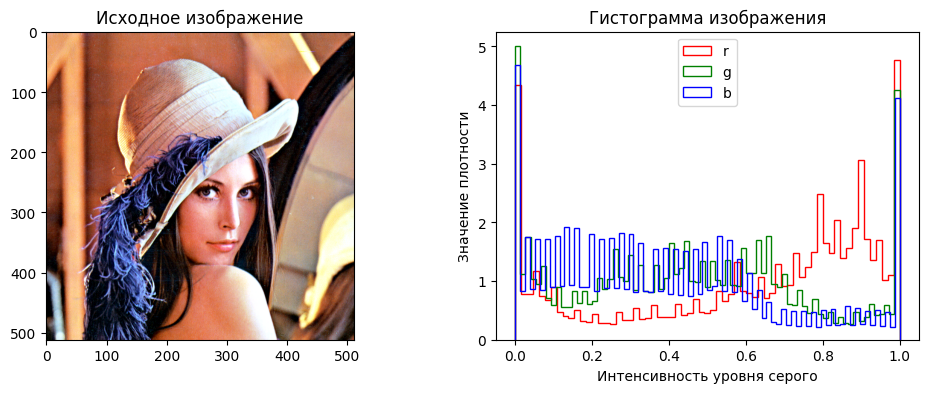

In [161]:
new_img = linear_hist_transform(img)
img_hist(new_img)

Динамика изменения изображения при разном пороговом значении n%

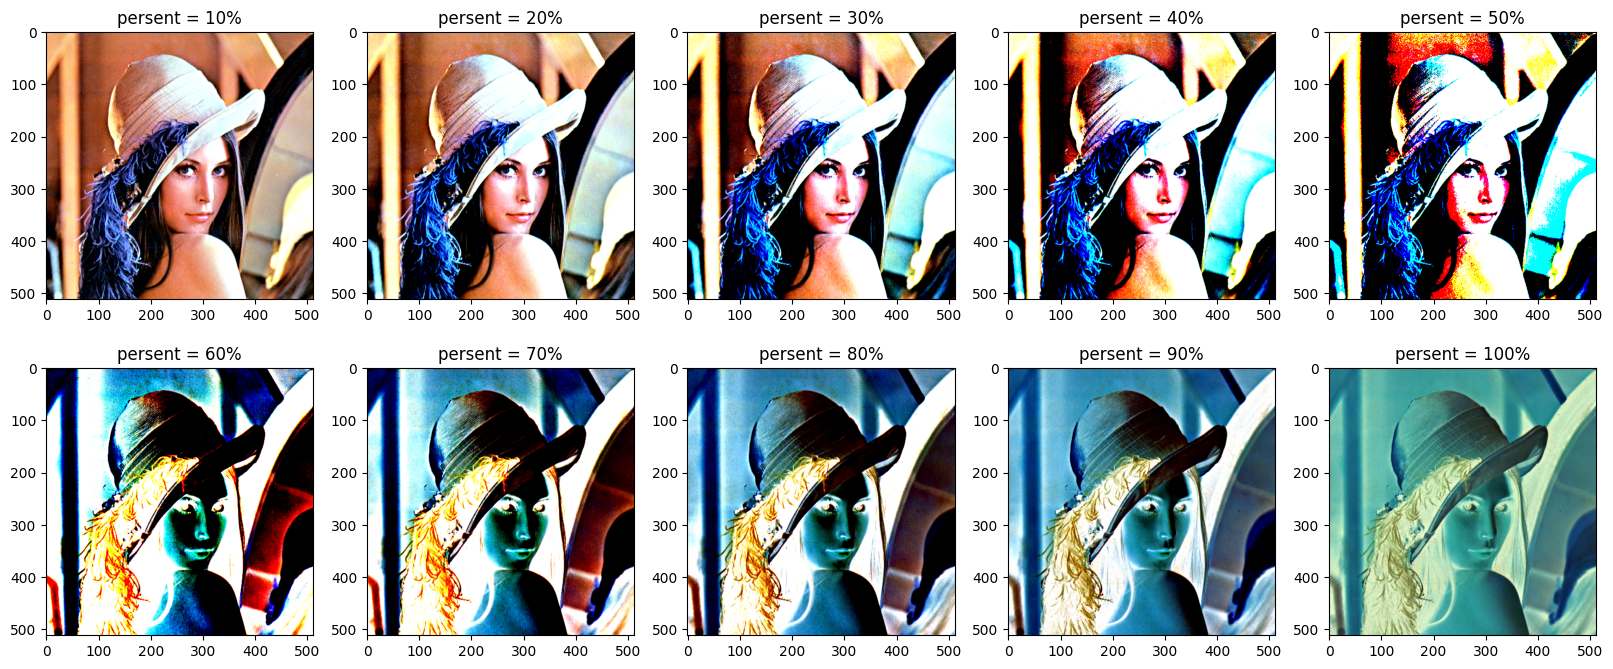

In [162]:
import matplotlib.pyplot as plt


persents = [
    range(10, 51, 10),
    range(60, 101, 10)
]

fig, ax = plt.subplots(len(persents), len(persents[0]), figsize=(20, 8))
for i, row in enumerate(persents):
    for j, val in enumerate(row):
        ax[i, j].set_title(f'persent = {val}%')
        ax[i, j].imshow(linear_hist_transform(img / 255, val / 100))

# Задание 4 Гамма коррекция

Для гамма-коррекции будет преобразовывать исходное изображение в HSV-формат, а затем применять гамма-преобразование к каналу V.

## 4.1 Функция RGB $\rightarrow$ HSV.

In [163]:
def rgb_to_hsv(image: np.ndarray) -> np.ndarray:
    """
    input:
        R, G, B: [0, 255]
    output:
        H: [0°, 360°]
        S: [0%, 100%]
        V: [0%, 100%]
    """
    temp_image = image.copy().astype(np.float64) / 255

    r, g, b = temp_image[:, :, 0], temp_image[:, :, 1], temp_image[:, :, 2]

    MAX = temp_image.max(axis=-1)
    MIN = temp_image.min(axis=-1)

    delta = MAX - MIN

    max_is_r = MAX == r
    max_is_g = MAX == g
    max_is_b = MAX == b
    g_geq_b = g >= b

    H = np.zeros_like(r)

    H[max_is_r & g_geq_b] = (60 * (g - b) / delta)[max_is_r & g_geq_b]
    H[max_is_r & np.invert(g_geq_b)] = (60 * (g - b) / delta + 360)[max_is_r & np.invert(g_geq_b)]
    H[max_is_g] = (60 * (b - r) / delta + 120)[max_is_g]
    H[max_is_b] = (60 * (r - g) / delta + 240)[max_is_b]

    H = np.nan_to_num(H)

    S = np.zeros_like(delta)
    S[MAX != 0] = (1 - MIN / MAX)[MAX != 0]

    return np.stack((H.astype(np.int16) % 360, S * 100, MAX * 100), axis=-1)

## 4.2 Функция HSV $\rightarrow$ RGB.

In [164]:
def hsv_to_rgb(image: np.ndarray) -> np.ndarray:
    """
    input:
        H: [0°, 360°]
        S: [0%, 100%]
        V: [0%, 100%]
    output:
        R, G, B: [0, 255]
    """
    temp_image = image.copy()
    H, S, V = temp_image[:, :, 0], temp_image[:, :, 1], temp_image[:, :, 2]

    H_i = np.floor(H / 60) % 6

    V_min = (100 - S) * V / 100
    alpha = (V - V_min) * (H % 60) / 60
    V_inc = V_min + alpha
    V_dec = V - alpha

    r, g, b = np.zeros_like(H), np.zeros_like(H), np.zeros_like(H)

    H_0 = H_i == 0
    H_1 = H_i == 1
    H_2 = H_i == 2
    H_3 = H_i == 3
    H_4 = H_i == 4
    H_5 = H_i == 5

    r[H_0], g[H_0], b[H_0] = V[H_0], V_inc[H_0], V_min[H_0]
    r[H_1], g[H_1], b[H_1] = V_dec[H_1], V[H_1], V_min[H_1]
    r[H_2], g[H_2], b[H_2] = V_min[H_2], V[H_2], V_inc[H_2]
    r[H_3], g[H_3], b[H_3] = V_min[H_3], V_dec[H_3], V[H_3]
    r[H_4], g[H_4], b[H_4] = V_inc[H_4], V_min[H_4], V[H_4]
    r[H_5], g[H_5], b[H_5] = V[H_5], V_min[H_5], V_dec[H_5]

    c = 255 / 100

    return (np.stack((r, g, b), axis=-1) * c).astype(np.uint8)

## 4.3 Имплементация функции для гамма-коррекции

Поскольку будем работать с форматом интенсивности пикселя от 0 до 1, получим, что значение $c = 1$ в формуле гамма-коррекции.

In [165]:
def gamma_transform(img: np.ndarray, gamma: float) -> np.ndarray:
    hue, saturation, value = rgb_to_hsv(img).transpose(2, 0, 1)
    new_value = ((value / 100) ** gamma) * 100
    return hsv_to_rgb(
        np.stack([
            hue, saturation, new_value
        ]).transpose(1, 2, 0)
    )

Пример работы гамма-коррекции при разных значениях $\gamma$

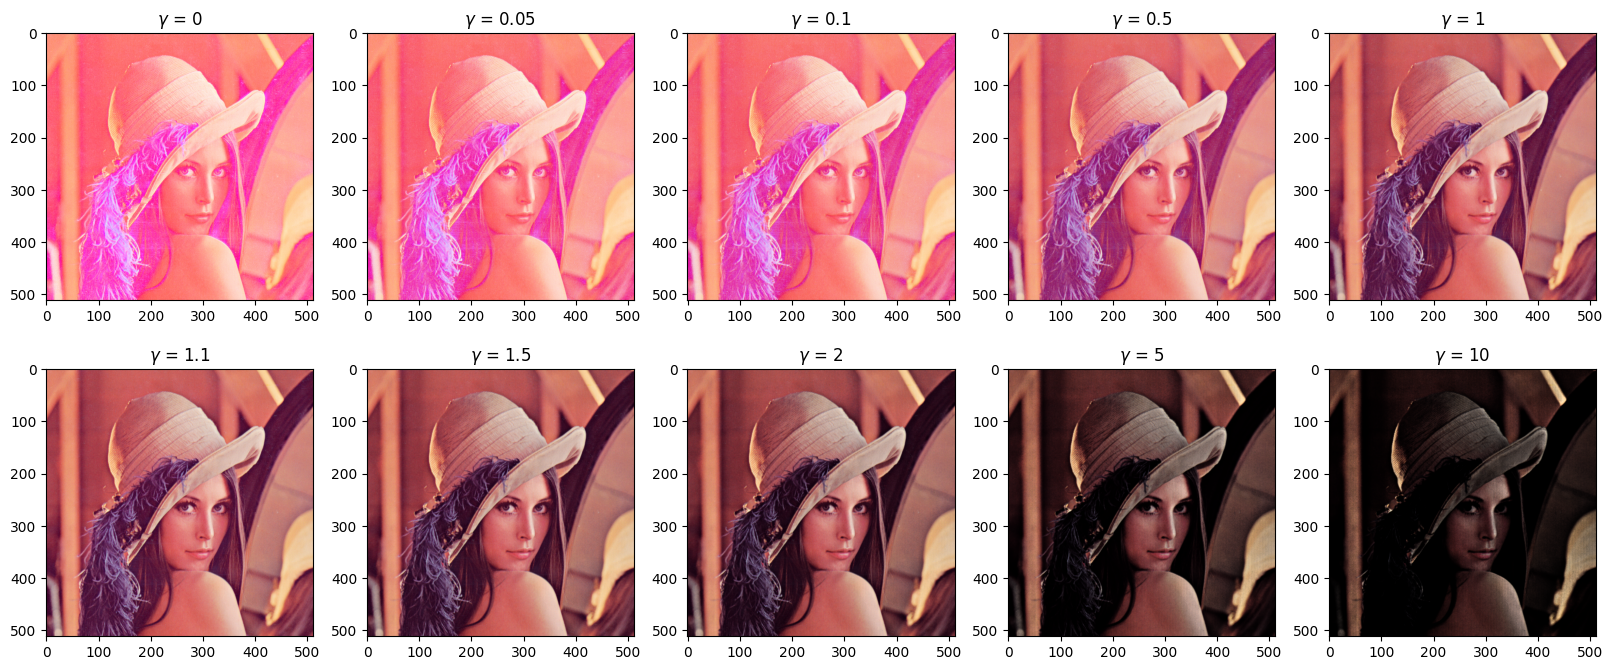

In [166]:
persents = [
    [0, 0.05, 0.1, 0.5, 1],
    [1.1, 1.5, 2, 5, 10]
]

fig, ax = plt.subplots(len(persents), len(persents[0]), figsize=(20, 8))
for i, row in enumerate(persents):
    for j, val in enumerate(row):
        ax[i, j].set_title(f'$\gamma$ = {val}')
        ax[i, j].imshow(gamma_transform(img, val))

# Задание 5 Эквализация гистограммы

In [167]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Unequalized_Hawkes_Bay_NZ.jpg/300px-Unequalized_Hawkes_Bay_NZ.jpg"
urllib.request.urlretrieve(url, "image_heq.jpg")

('image_heq.jpg', <http.client.HTTPMessage at 0x7d78e058b550>)

## 5.1 Загрузка изображения

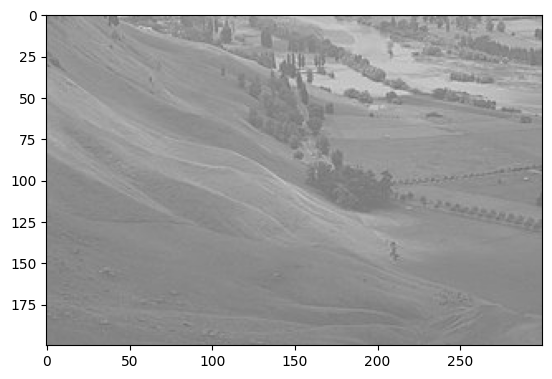

In [168]:
img = cv2.imread("image_heq.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

## 5.2 Реализация метода эквализации гистограммы

In [169]:
def hist_eq_channel(img_channel: np.ndarray) -> np.ndarray:
    L = 255
    variation_series, counts = np.unique(img_channel, return_counts=True)
    p_n = counts / np.prod(img_channel.shape)
    dist = dict(zip(variation_series, p_n))
    f = np.vectorize(lambda k: np.floor(L * np.sum([
        dist.get(pixel_value, 0) for pixel_value in range(k)
    ])))
    return f(img_channel)

In [170]:
def hist_eq(img: np.ndarray) -> np.ndarray:
    return np.stack([
        hist_eq_channel(channel) for channel in img.transpose(2, 0, 1)
    ]).transpose(1, 2, 0).astype(int)

Примеры эквализированных изображений и гистограмм

Исходное изображение и гистограмма

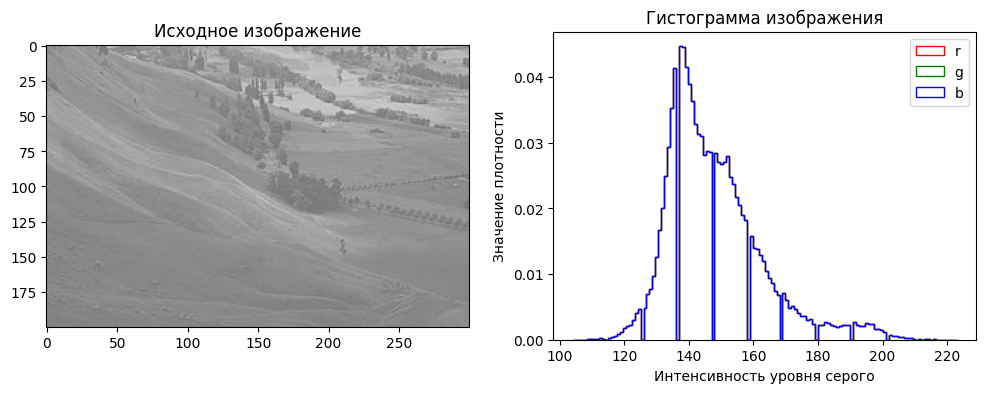

In [171]:
img_hist(img)

Зквализированное изображение и гистограмма

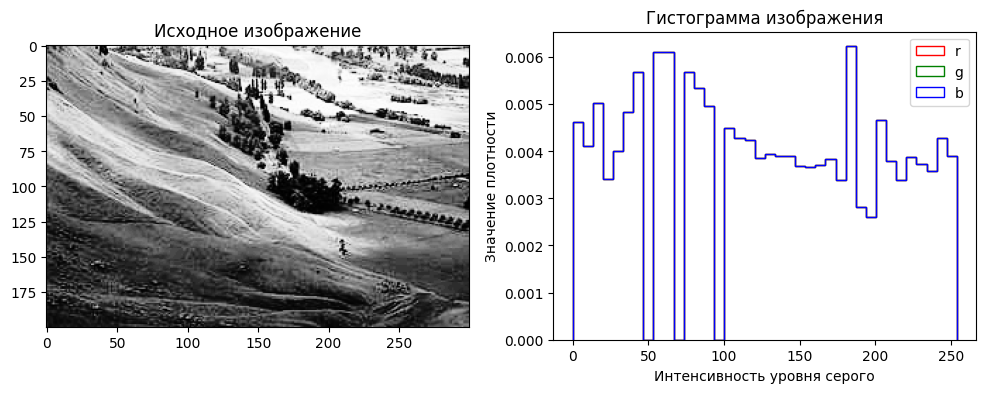

In [172]:
new_image = hist_eq(img)
img_hist(new_image)